## Parameters

In [1]:
LAMBDA = 0.5
CENTER_LOSS_ALPHA = 0.5
NUM_CLASSES = 10

## Import modules

In [2]:
import os
import numpy as np
import tensorflow as tf
import tflearn
from tensorflow.examples.tutorials.mnist import input_data

slim = tf.contrib.slim
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Construct network

In [3]:
with tf.name_scope('input'):
    input_images = tf.placeholder(tf.float32, shape=(None,28,28,1), name='input_images')
    labels = tf.placeholder(tf.int64, shape=(None), name='labels')
    
global_step = tf.Variable(0, trainable=False, name='global_step')

In [4]:
def get_center_loss(features, labels, alpha, num_classes):
    """获取center loss及center的更新op
    
    Arguments:
        features: Tensor,表征样本特征,一般使用某个fc层的输出,shape应该为[batch_size, feature_length].
        labels: Tensor,表征样本label,非one-hot编码,shape应为[batch_size].
        alpha: 0-1之间的数字,控制样本类别中心的学习率,细节参考原文.
        num_classes: 整数,表明总共有多少个类别,网络分类输出有多少个神经元这里就取多少.
    
    Return：
        loss: Tensor,可与softmax loss相加作为总的loss进行优化.
        centers: Tensor,存储样本中心值的Tensor，仅查看样本中心存储的具体数值时有用.
        centers_update_op: op,用于更新样本中心的op，在训练时需要同时运行该op，否则样本中心不会更新
    """
    # 获取特征的维数，例如256维
    len_features = features.get_shape()[1]
    # 建立一个Variable,shape为[num_classes, len_features]，用于存储整个网络的样本中心，
    # 设置trainable=False是因为样本中心不是由梯度进行更新的
    centers = tf.get_variable('centers', [num_classes, len_features], dtype=tf.float32,
        initializer=tf.constant_initializer(0), trainable=False)
    # 将label展开为一维的，输入如果已经是一维的，则该动作其实无必要
    labels = tf.reshape(labels, [-1])
    
    # 根据样本label,获取mini-batch中每一个样本对应的中心值
    centers_batch = tf.gather(centers, labels)
    # 计算loss
    loss = tf.nn.l2_loss(features - centers_batch)
    
    # 当前mini-batch的特征值与它们对应的中心值之间的差
    diff = centers_batch - features
    
    # 获取mini-batch中同一类别样本出现的次数,了解原理请参考原文公式(4)
    unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
    appear_times = tf.gather(unique_count, unique_idx)
    appear_times = tf.reshape(appear_times, [-1, 1])
    
    diff = diff / tf.cast((1 + appear_times), tf.float32)
    diff = alpha * diff
    
    centers_update_op = tf.scatter_sub(centers, labels, diff)
    
    return loss, centers, centers_update_op

In [5]:
def inference(input_images):
    with slim.arg_scope([slim.conv2d], kernel_size=3, padding='SAME'):
        with slim.arg_scope([slim.max_pool2d], kernel_size=2):
            
            x = slim.conv2d(input_images, num_outputs=32, scope='conv1_1')
            x = slim.conv2d(x, num_outputs=32, scope='conv1_2')
            x = slim.max_pool2d(x, scope='pool1')
     
            x = slim.conv2d(x, num_outputs=64, scope='conv2_1')
            x = slim.conv2d(x, num_outputs=64, scope='conv2_2')
            x = slim.max_pool2d(x, scope='pool2')
            
            x = slim.conv2d(x, num_outputs=128, scope='conv3_1')
            x = slim.conv2d(x, num_outputs=128, scope='conv3_2')
            x = slim.max_pool2d(x, scope='pool3')
            
            x = slim.flatten(x, scope='flatten')
            
            feature = slim.fully_connected(x, num_outputs=2, activation_fn=None, scope='fc1')
            
            x = tflearn.prelu(feature)

            x = slim.fully_connected(x, num_outputs=10, activation_fn=None, scope='fc2')
    
    return x, feature

In [6]:
def build_network(input_images, labels, ratio=0.5):
    logits, features = inference(input_images)
    
    with tf.name_scope('loss'):
        with tf.name_scope('center_loss'):
            center_loss, centers, centers_update_op = get_center_loss(features, labels, CENTER_LOSS_ALPHA, NUM_CLASSES)
        with tf.name_scope('softmax_loss'):
            softmax_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        with tf.name_scope('total_loss'):
            total_loss = softmax_loss # + ratio * center_loss
    
    with tf.name_scope('acc'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(logits, 1), labels), tf.float32))
    
    with tf.name_scope('loss/'):
        tf.summary.scalar('CenterLoss', center_loss)
        tf.summary.scalar('SoftmaxLoss', softmax_loss)
        tf.summary.scalar('TotalLoss', total_loss)
        
    return logits, features, total_loss, accuracy, centers_update_op

In [7]:
logits, features, total_loss, accuracy, centers_update_op = build_network(input_images, labels, ratio=LAMBDA)

## Prepare data

In [8]:
mnist = input_data.read_data_sets('/tmp/mnist', reshape=False)

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


## Optimizer

In [9]:
optimizer = tf.train.AdamOptimizer(0.001)

In [10]:
with tf.control_dependencies([centers_update_op]):
    train_op = optimizer.minimize(total_loss, global_step=global_step)

## Session and Summary

In [11]:
summary_op = tf.summary.merge_all()

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('/tmp/mnist_log', sess.graph)

## Train

In [13]:
mean_data = np.mean(mnist.train.images, axis=0)

In [14]:
step = sess.run(global_step)
while step <= 8000:
    batch_images, batch_labels = mnist.train.next_batch(128)
    _, summary_str, train_acc = sess.run(
        [train_op, summary_op, accuracy],
        feed_dict={
            input_images: batch_images - mean_data,
            labels: batch_labels,
        })
    step += 1
    
    writer.add_summary(summary_str, global_step=step)
    
    if step % 200 == 0:
        vali_image = mnist.validation.images - mean_data
        vali_acc = sess.run(
            accuracy,
            feed_dict={
                input_images: vali_image,
                labels: mnist.validation.labels
            })
        print(("step: {}, train_acc:{:.4f}, vali_acc:{:.4f}".
              format(step, train_acc, vali_acc)))

step: 200, train_acc:0.6484, vali_acc:0.7172
step: 400, train_acc:0.8047, vali_acc:0.8146
step: 600, train_acc:0.9062, vali_acc:0.9124
step: 800, train_acc:0.9609, vali_acc:0.9496
step: 1000, train_acc:0.9922, vali_acc:0.9616
step: 1200, train_acc:0.9375, vali_acc:0.9670
step: 1400, train_acc:0.9453, vali_acc:0.9610
step: 1600, train_acc:0.9922, vali_acc:0.9700
step: 1800, train_acc:1.0000, vali_acc:0.9726
step: 2000, train_acc:0.9844, vali_acc:0.9796
step: 2200, train_acc:0.9922, vali_acc:0.9794
step: 2400, train_acc:0.9844, vali_acc:0.9718
step: 2600, train_acc:0.9844, vali_acc:0.9832
step: 2800, train_acc:0.9844, vali_acc:0.9808
step: 3000, train_acc:0.9922, vali_acc:0.9814
step: 3200, train_acc:1.0000, vali_acc:0.9834
step: 3400, train_acc:0.9766, vali_acc:0.9806
step: 3600, train_acc:0.9922, vali_acc:0.9828
step: 3800, train_acc:0.9844, vali_acc:0.9824
step: 4000, train_acc:0.9844, vali_acc:0.9792
step: 4200, train_acc:0.9922, vali_acc:0.9838
step: 4400, train_acc:0.9766, vali_acc

### Visualize train_data

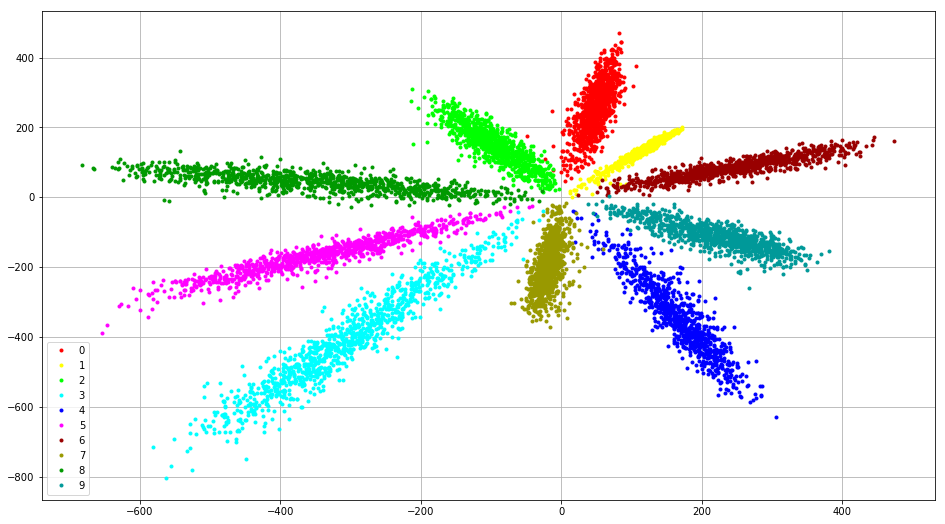

In [15]:
feat = sess.run(features, feed_dict={input_images:mnist.train.images[:10000]-mean_data})

%matplotlib inline
import matplotlib.pyplot as plt

labels = mnist.train.labels[:10000]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']
for i in range(10):
    plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.grid()
plt.show()

### Visualize test_data

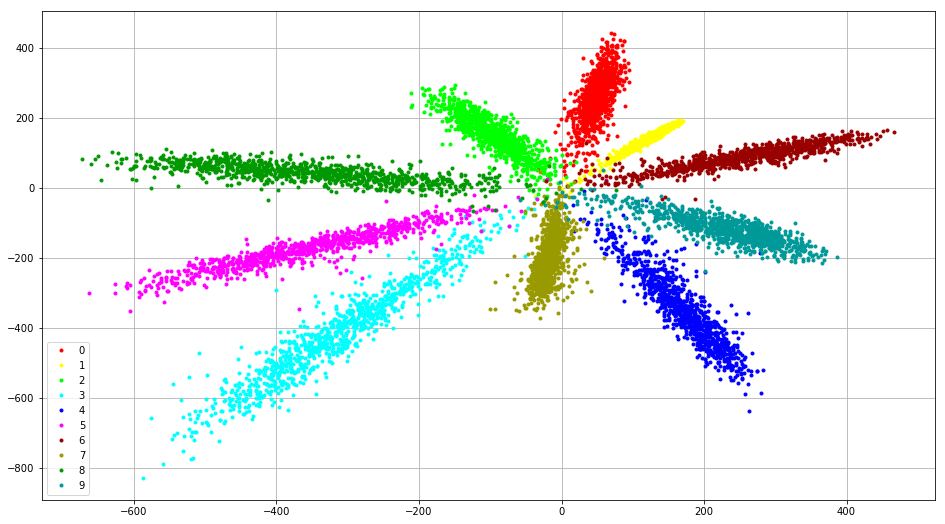

In [16]:
feat = sess.run(features, feed_dict={input_images:mnist.test.images[:10000]-mean_data})

%matplotlib inline
import matplotlib.pyplot as plt

labels = mnist.test.labels[:10000]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']
for i in range(10):
    plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.grid()
plt.show()

In [18]:
sess.close()